In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.get_cluster import C_rsmso,cluster_os
from TO_sim.To_Draw import Draw_avg_vel_r

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import parmap

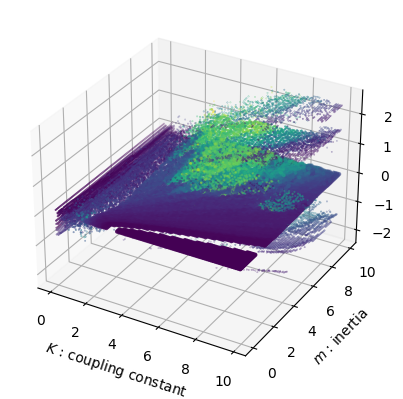

In [5]:
df = pd.read_excel('test 230620.xlsm',index_col=[0,1])
df = pd.read_excel('N = 500 seed = 10 test 230621.xlsm',index_col=[0,1])
# df_Km = df.reset_index(['K','m'])
KK = df.index.to_frame().K.unstack().to_numpy().T
MM = df.index.to_frame().m.unstack().to_numpy().T
# origin = 'lower'
# CS = plt.contourf(KK,MM,df['rMM'].unstack().T, 20, cmap=plt.cm.viridis, origin=origin)
# CS2 = plt.contour(CS, levels=CS.levels[::], colors='k',linewidths = 0.5, origin=origin)
# plt.colorbar()
Ks = df.reset_index().K
ms = df.reset_index().m
Ss_c0 = df.reset_index()['S c0'].to_numpy()
Ss_c1 = df.reset_index()['S c1'].to_numpy()
Ss_c2 = df.reset_index()['S c2'].to_numpy()
Ss_c3 = df.reset_index()['S c3'].to_numpy()
Ss_c4 = df.reset_index()['S c4'].to_numpy()
Ss_c5 = df.reset_index()['S c5'].to_numpy()

So_c0 = df.reset_index()['S c0 omega'].to_numpy()
So_c1 = df.reset_index()['S c1 omega'].to_numpy()
So_c2 = df.reset_index()['S c2 omega'].to_numpy()
So_c3 = df.reset_index()['S c3 omega'].to_numpy()
So_c4 = df.reset_index()['S c4 omega'].to_numpy()
So_c5 = df.reset_index()['S c5 omega'].to_numpy()

rMM = df.reset_index()['rMM']


# plt.subplot(projection='3d')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Ks,ms,So_c0,c=rMM,s=Ss_c0*0.01)
ax.scatter(Ks,ms,So_c1,c=rMM,s=Ss_c1*0.01)
ax.scatter(Ks,ms,So_c2,c=rMM,s=Ss_c2*0.01)
ax.scatter(Ks,ms,So_c3,c=rMM,s=Ss_c3*0.01)
ax.scatter(Ks,ms,So_c4,c=rMM,s=Ss_c4*0.01)
ax.scatter(Ks,ms,So_c5,c=rMM,s=Ss_c5*0.01)

ax.set_xlabel('$K$ : coupling constant')
ax.set_ylabel('$m$ : inertia')
ax.set_zlabel('cluster phase velocity')
# plt.zlim(-0.)
# plt.scatter(Ks,ms,Ss,Ss)
plt.show()


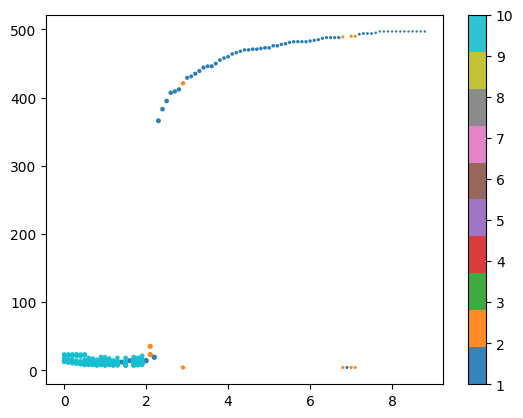

In [8]:
m_idx = 20
ms = df.reset_index().m.unique()
re_df = df.reset_index()

df_m = re_df[re_df.m == ms[m_idx]]
Ks = df_m.K.to_numpy()
rs = df_m.r.to_numpy()
rstd = df_m.rstd.to_numpy()
rMM= df_m.rMM.to_numpy()
cluster_s = df_m.iloc[:,5:15]
cluster_o = df_m.iloc[:,15:25]

len_cluster = (~cluster_o.isna()).sum(axis=1).to_numpy()
plt.scatter(np.ones((10,100))*Ks,cluster_s.to_numpy().T,alpha=0.9,
            c=np.ones((10,100))*(len_cluster),s=50*np.ones((10,100))*rMM,cmap='tab10')
plt.colorbar()

In [11]:
len_cluster = (~cluster_o.isna()).sum(axis=1)
df_m.K.loc[df_m.K>2][len_cluster ==0]

8920    8.9
9020    9.0
9120    9.1
9220    9.2
9320    9.3
9420    9.4
9520    9.5
9620    9.6
9720    9.7
9820    9.8
9920    9.9
Name: K, dtype: float64

## RK4 수정 ensemble version으로

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.get_cluster import C_rsmso,cluster_os
from TO_sim.To_Draw import Draw_avg_vel_r

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
import parmap

In [2]:
seed =10
N = 500
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
omega = np.sort(omega) 
K = 5
m = 5
t_end = 5000
dt =0.1
t = np.arange(0,t_end,dt)
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_init,p_dtheta= 0*omega,p_omega=omega,result_time = int((t_end)-(600))*int(1/dt))
if m == 0:
        dtheta = np.c_[dtheta[0],dtheta.T].T

In [68]:
def get_order_parameter(theta,N):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta))
    r = np.abs(rpsi)
    psi = np.angle(rpsi)
    return r,psi

def get_order_parameter_sets(theta,N,M):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta),axis=1)
    r = np.abs(rpsi).reshape((-1,1))
    psi = np.angle(rpsi).reshape((-1,1))
    return r,psi

def Kuramoto_2nd_mf(Theta,t,omega,N,m,K):
    # print(f"Case m = {m}") 
    # theta,dtheta,r,psi = Theta[:N],Theta[N:2*N],Theta[-2],Theta[-1]
    theta,dtheta = Theta[:N],Theta[N:2*N]
    r,psi = get_order_parameter(theta,N)
    ddtheta = (1/m)*(-dtheta + omega + K*r*np.sin(psi - theta))
    return np.r_[dtheta,ddtheta]


In [70]:
1/N*np.sum(np.exp(1j*theta_sets),axis=1).shape

TypeError: can't multiply sequence by non-int of type 'float'

In [4]:
N_set = 10
theta_sets = (np.ones((N_set,1))*np.r_[theta_init,np.zeros_like(theta_init)])
omega_sets = (np.ones((N_set,1))*omega)
K_set = np.arange(10).reshape(-1,1)
m_set = np.arange(1,11).reshape(-1,1)
def Kuramoto_2nd_mf_sets(Theta_sets,t,omega_sets,N,m,K_set,N_set):
    theta,dtheta = theta_sets[:,:N],theta_sets[:,N:2*N]
    r,psi = get_order_parameter_sets(theta,N,N_set)
    ddtheta = (1/m)*(-dtheta + omega_sets + K_set*r*np.sin(psi - theta))
    return np.c_[dtheta,ddtheta]


def Kuramoto_2nd_mf_sets_r(Theta_sets,t,omega_sets,N,m,K_set,N_set):
    theta,dtheta = theta_sets[:,:N],theta_sets[:,N:2*N]
    r,psi = get_order_parameter_sets(theta,N,N_set)
    ddtheta = (1/m)*(-dtheta + omega_sets + K_set*r*np.sin(psi - theta))
    return np.c_[dtheta,ddtheta],r

In [67]:
np.c_[theta_sets,theta_sets].shape

(10, 2000)

In [5]:
A = theta_sets
As = np.zeros((10, *A.shape))

In [6]:
As[0] = A

In [7]:
n = 2
y = np.zeros((n, *A.shape))
y[0] = A
f = Kuramoto_2nd_mf_sets
args = (omega_sets,N,m,K_set,N_set)
for i in range(n - 1):
    h = t[i + 1] - t[i]
    k1 = f(y[i], t[i], *args)
    k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
    k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
    k4 = f(y[i] + k3 * h, t[i] + h, *args)
    y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

In [43]:
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, *y0.shape))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y

In [170]:
f = Kuramoto_2nd_mf
args = (omega,N,m,K)
RK4(f,np.r_[theta_init,np.ones_like(theta_init)],t,args = args)

array([[ 1.70475788e+00, -3.01120431e+00,  8.39736626e-01, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.80054999e+00, -2.91525188e+00,  9.36414953e-01, ...,
         1.02710838e+00,  1.03098161e+00,  1.03524134e+00],
       [ 1.88803818e+00, -2.82728786e+00,  1.02653826e+00, ...,
         1.05367990e+00,  1.06134988e+00,  1.06978678e+00],
       ...,
       [-1.59588429e+04, -1.48321691e+04, -1.18635407e+04, ...,
         2.78429042e+00,  2.76119323e+00,  2.41057953e+00],
       [-1.59591767e+04, -1.48324448e+04, -1.18638061e+04, ...,
         2.75830361e+00,  2.71854854e+00,  2.39131123e+00],
       [-1.59595148e+04, -1.48327236e+04, -1.18640673e+04, ...,
         2.71598768e+00,  2.66296973e+00,  2.38850885e+00]])

In [8]:
N_set = 20
theta_sets = (np.ones((N_set,1))*np.r_[theta_init,np.zeros_like(theta_init)])
omega_sets = (np.ones((N_set,1))*np.sort(omega))
K_set = np.arange(N_set).reshape(-1,1)

In [205]:
np.arange(N_set).reshape(-1,1).shape

(20, 1)

In [ ]:
f = Kuramoto_2nd_mf_sets
args = (omega_sets,N,m,K_set,N_set)
RK4(f,theta_sets,t,args = args)

In [56]:
theta_sets.shape

(10, 1000)

In [64]:
np.arange(10).reshape(-1,1)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [63]:
1/N*np.sum(np.exp(1j*theta_sets),axis=(1)).reshape((-1,1))

array([[1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j],
       [1.00373695+0.01964693j]])

In [ ]:
def Sol_Kuramoto_mf2(K,N,m,t_array,p_theta = [], p_dtheta = [], p_omega = [],result_time = 0):
    theta, dtheta, omega  =  p_theta, p_dtheta,p_omega
    if m==0:
        function = Kuramoto_1st_mf_r
    else:
        function = Kuramoto_2nd_mf_r
    result,rs = RK4_r(function,np.r_[theta,dtheta],t_array,args=(omega,N,m,K),result_time=result_time)
    theta_s = result[:,:N]
    dtheta_s = result[:,N:2*N]
    if m == 0:
        dt = t_array[1]-t_array[0]
        dtheta_s = np.diff(theta_s/dt,axis=0)
    return theta_s,dtheta_s,rs

In [11]:
def get_order_parameter(theta,N):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta))
    r = np.abs(rpsi)
    psi = np.angle(rpsi)
    return r,psi

def get_order_parameter_sets(theta,N,M):
    ''' get theta and return r and theta'''
    rpsi = 1/N*np.sum(np.exp(1j*theta),axis=1)
    r = np.abs(rpsi).reshape((-1,1))
    psi = np.angle(rpsi).reshape((-1,1))
    return r,psi

def Kuramoto_2nd_mf(Theta,t,omega,N,m,K):
    # print(f"Case m = {m}") 
    # theta,dtheta,r,psi = Theta[:N],Theta[N:2*N],Theta[-2],Theta[-1]
    theta,dtheta = Theta[:N],Theta[N:2*N]
    r,psi = get_order_parameter(theta,N)
    ddtheta = (1/m)*(-dtheta + omega + K*r*np.sin(psi - theta))
    return np.r_[dtheta,ddtheta]


In [41]:
np.sin([[1,2,3,4,5],[1,2,3,4,5]])

array([[ 0.84147098,  0.90929743,  0.14112001, -0.7568025 , -0.95892427],
       [ 0.84147098,  0.90929743,  0.14112001, -0.7568025 , -0.95892427]])

In [95]:
def RK4_r_sets(f, y0, t, args=(),result_time = 0):
    n = len(t) - result_time
    y = np.zeros((n, *y0.shape))
    _,N,_,_,N_set = args
    rs = np.zeros((n+result_time,N_set,1))
    y[0] = y0
    h = t[1] - t[0]
    rs[0] = abs(1/N*np.sum(np.exp(1j*y0[:,:N]),axis=1)).reshape((-1,1))
    y_ = y0
    j = 0
    for i in range(result_time):
        k1,r = f(y_, t, *args)
        k2,_ = f(y_ + k1 * h / 2.0, t + h / 2.0, *args)
        k3,_ = f(y_ + k2 * h / 2.0, t + h / 2.0, *args)
        k4,_ = f(y_ + k3 * h, t + h, *args)
        y_ = y_ + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        rs[j+1] = r
        j+=1
    y[0] = y_
    for i in range(n - 1):
        k1,r = f(y[i], t[i], *args)
        k2,_ = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3,_ = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4,_ = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        rs[j+1] = r
        j+=1
    return y,rs

In [13]:
As = np.zeros((5,10,1))
As[0] = np.arange(10).reshape((-1,1))

In [14]:
np.arange(10).reshape((-1,1)).shape

(10, 1)

In [15]:
np.arange(10).reshape((-1,1)).shape

(10, 1)

In [16]:
np.arange(10).reshape((-1,1))

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [54]:
omega_sets

array([[-3.20440134, -2.97959677, -2.39557201, ...,  2.46532508,
         2.46765106,  2.67991031],
       [-3.20440134, -2.97959677, -2.39557201, ...,  2.46532508,
         2.46765106,  2.67991031],
       [-3.20440134, -2.97959677, -2.39557201, ...,  2.46532508,
         2.46765106,  2.67991031],
       ...,
       [-3.20440134, -2.97959677, -2.39557201, ...,  2.46532508,
         2.46765106,  2.67991031],
       [-3.20440134, -2.97959677, -2.39557201, ...,  2.46532508,
         2.46765106,  2.67991031],
       [-3.20440134, -2.97959677, -2.39557201, ...,  2.46532508,
         2.46765106,  2.67991031]])

In [96]:
N_set = 10
theta_sets = (np.ones((N_set,1))*np.r_[theta_init,np.zeros_like(theta_init)])
omega_sets = (np.ones((N_set,1))*np.sort(omega))
K_set = np.arange(N_set).reshape(-1,1)
f = Kuramoto_2nd_mf_sets_r
args = (omega_sets,N,m,K_set,N_set)
Result,rs = RK4_r_sets(f,theta_sets,t,args = args)

In [97]:
rs

array([[[0.2447541],
        [0.2447541],
        [0.2447541],
        ...,
        [0.2447541],
        [0.2447541],
        [0.2447541]],

       [[0.2447541],
        [0.2447541],
        [0.2447541],
        ...,
        [0.2447541],
        [0.2447541],
        [0.2447541]],

       [[0.2447541],
        [0.2447541],
        [0.2447541],
        ...,
        [0.2447541],
        [0.2447541],
        [0.2447541]],

       ...,

       [[0.2447541],
        [0.2447541],
        [0.2447541],
        ...,
        [0.2447541],
        [0.2447541],
        [0.2447541]],

       [[0.2447541],
        [0.2447541],
        [0.2447541],
        ...,
        [0.2447541],
        [0.2447541],
        [0.2447541]],

       [[0.2447541],
        [0.2447541],
        [0.2447541],
        ...,
        [0.2447541],
        [0.2447541],
        [0.2447541]]])

In [44]:
f = Kuramoto_2nd_mf_sets
args = (omega_sets,N,m,K_set,N_set)
Result = RK4(f,theta_sets,t,args = args)

In [45]:
dthetas = Result[:,:,N:]
thetas = Result[:,:,:N]

In [46]:
r_,psi_ = get_order_parameter_sets(thetas,N,N_set)

In [47]:
r_.shape

(25000000, 1)

In [202]:
rpsi = 1/N*np.sum(np.exp(1j*theta_sets[:,:N]),axis=1)
r = np.abs(rpsi).reshape(1,-1)
psi = np.angle(rpsi).reshape(1,-1)
psi.shape

(1, 20)

In [201]:
theta_sets.shape

(20, 1000)

In [197]:
rpsi

array([0.00373695+0.01964693j, 0.00373695+0.01964693j,
       0.00373695+0.01964693j, 0.00373695+0.01964693j,
       0.00373695+0.01964693j, 0.00373695+0.01964693j,
       0.00373695+0.01964693j, 0.00373695+0.01964693j,
       0.00373695+0.01964693j, 0.00373695+0.01964693j,
       0.00373695+0.01964693j, 0.00373695+0.01964693j,
       0.00373695+0.01964693j, 0.00373695+0.01964693j,
       0.00373695+0.01964693j, 0.00373695+0.01964693j,
       0.00373695+0.01964693j, 0.00373695+0.01964693j,
       0.00373695+0.01964693j, 0.00373695+0.01964693j])

In [32]:
def Make_order_parameter(theta_s,N):
    rs = np.abs(np.sum(np.exp(1j*theta_s.T),axis=0))/N
    return rs

In [37]:
thetas.shape

(50000, 10, 500)

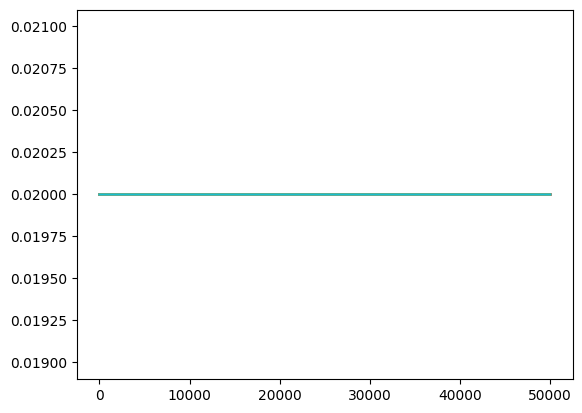

In [48]:
plt.plot((np.abs(np.sum(np.exp(1j*thetas),axis=2))/N))

In [50]:
K

5

In [51]:
f = Kuramoto_2nd_mf
args = (omega,N,m,K)
result = RK4(f,np.r_[theta_init,np.ones_like(theta_init)],t,args = args)
theta = result[:,:N]

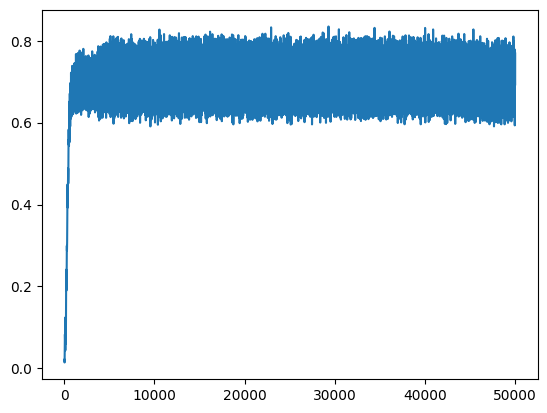

In [53]:
plt.plot((np.abs(np.sum(np.exp(1j*theta),axis=1))/N))


In [72]:
seed =10
N = 20
theta_init,omega,Kc = Normal(N,0,1,seed=seed)
omega = np.sort(omega) 
K = 5
m = 5
t_end = 5000
dt =0.1
t = np.arange(0,t_end,dt)
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_init,p_dtheta= 0*omega,p_omega=omega,result_time = int((t_end)-(600))*int(1/dt))
if m == 0:
        dtheta = np.c_[dtheta[0],dtheta.T].T

In [76]:
N_set = 10
theta_sets = (np.ones((N_set,1))*np.r_[theta_init,np.zeros_like(theta_init)])
omega_sets = (np.ones((N_set,1))*omega)
K_set = np.arange(10).reshape(-1,1)
m_set = np.arange(1,11).reshape(-1,1)



def Kuramoto_2nd_mf_sets_r(Theta_sets,t,omega_sets,N,m,K_set,N_set):
    theta,dtheta = theta_sets[:,:N],theta_sets[:,N:2*N]
    r,psi = get_order_parameter_sets(theta,N,N_set)
    ddtheta = (1/m)*(-dtheta + omega_sets + K_set*r*np.sin(psi - theta))
    return np.c_[dtheta,ddtheta],r

In [78]:
y0 = np.zeros((10,*theta_sets.shape))
y0[0] = theta_sets
i = 0

In [93]:
theta,dtheta = theta_sets[:,:N],theta_sets[:,N:2*N]
r,psi = get_order_parameter_sets(theta,N,N_set)
ddtheta = (1/m)*(-dtheta + omega_sets + K_set*r*np.sin(psi - theta))
theta_sets = np.c_[dtheta,ddtheta]
y0[i] = theta_sets
i+=1

In [94]:
theta_sets

array([[-2.57570012e-01, -1.89436127e-01, -1.79969785e-01,
        -1.60846337e-01, -1.20015796e-01, -2.91004076e-02,
        -1.39732621e-03,  7.15247644e-04,  1.80916525e-02,
         2.25231014e-02,  3.81055094e-02,  4.42524974e-02,
         7.21719554e-02,  7.41905518e-02,  1.03557321e-01,
         1.19214688e-01,  1.71381207e-01,  2.00508795e-01,
         2.21933925e-01,  2.47426001e-01, -2.57566056e-01,
        -1.89433217e-01, -1.79967020e-01, -1.60843867e-01,
        -1.20013953e-01, -2.90999606e-02, -1.39730474e-03,
         7.15236658e-04,  1.80913746e-02,  2.25227554e-02,
         3.81049241e-02,  4.42518177e-02,  7.21708469e-02,
         7.41894122e-02,  1.03555731e-01,  1.19212857e-01,
         1.71378574e-01,  2.00505716e-01,  2.21930516e-01,
         2.47422200e-01],
       [-2.17781690e-01, -1.59305018e-01, -1.51165463e-01,
        -1.34778605e-01, -9.97982615e-02, -2.20113425e-02,
         1.68103152e-03,  3.49338516e-03,  1.83470315e-02,
         2.21353827e-02,  3.54

In [17]:
np.abs(np.sum(np.exp(1j*theta),axis=1))
np.angle(np.sum(np.exp(1j*theta),axis=1))

array([1.38283635, 1.38283635])